In [1]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from tqdm import tqdm
from PIL import Image, ImageDraw, ImageFont
import pandas as pd
import numpy as np
import cv2
import os
from skimage.morphology import convex_hull_image, binary_closing, square, dilation
from scipy import ndimage

In [2]:
#  load all images from a directory
def load_images_from_folder(folder):
    images = []
    filenames = []
    for filename in tqdm(os.listdir(folder)):
        try:
            img = Image.open(os.path.join(folder,filename))
            if img is not None:
                if img.mode != 'RGB':
                    img = img.convert('RGB')
                img = np.array(img)
                images.append(img)
                filenames.append(filename)
        except Exception as e:
            print(e)
    return images, filenames

In [3]:
# load all jsons from a directory
def load_jsons_from_folder(folder):
    jsons = []
    filenames = []
    for filename in tqdm(os.listdir(folder)):
        try:
            json = pd.read_json(os.path.join(folder,filename))
            if json is not None:
                jsons.append(json)
                filenames.append(filename)
        except Exception as e:
            print(e)
    return jsons, filenames

In [4]:
LOAD_CLEAN = False
if LOAD_CLEAN:
    human_parsing = load_images_from_folder('Task/dataset/human_parsing')
    image = load_images_from_folder('Task/dataset/image')
    pose_json = load_jsons_from_folder('Task/dataset/pose_json')
    pose_img = load_images_from_folder('Task/dataset/pose_img')
    df = pd.DataFrame()
    df['human_parsing'] = human_parsing[0]
    df['image'] = image[0]
    df['pose_json'] = pose_json[0]
    df['pose_img'] = pose_img[0]
    df['ids'] = [a.split('.')[0] for a in image[1]]
    df['pose_keypoints'] = df.pose_json.apply(lambda x: x.people[0].get('pose_keypoints_2d'))
    left_ankles = [a[3*11:3*12-1] for a in tqdm(df.pose_keypoints)]
    right_ankles = [a[3*14:3*15-1] for a in tqdm(df.pose_keypoints)]
    df['left_ankles'] = left_ankles
    df['right_ankles'] = right_ankles
    df.to_pickle('df.pkl')
else:
    df = pd.read_pickle('df.pkl')

In [5]:
def get_color_mask(img, colors):
    mask = np.zeros(img.shape[:2], dtype=np.uint8)
    for color in colors:
        mask += np.all(img == color, axis=-1).astype(np.uint8)
    return mask

def clean_outliers(mask):
    labels, num_labels = ndimage.label(mask)
    component_sizes = ndimage.sum(mask, labels, range(num_labels + 1))
    mask_largest_component = (labels == component_sizes.argmax())
    return mask_largest_component

def apply_mask(img, mask):
    img = np.array(img)
    img[mask] = (128, 128, 128)
    return Image.fromarray(img)

def ankle_mask(img, left_ankle, right_ankle):
    try:
        img = np.array(img)
        mask = np.zeros(img.shape[:2], dtype=np.uint8)
        x = [left_ankle[0], right_ankle[0]]
        y = [left_ankle[1], right_ankle[1]]
        m = (y[1] - y[0]) / (x[1] - x[0])
        b = y[0] - m * x[0]
        for i in range(img.shape[0]):
            for j in range(img.shape[1]):
                if i > m * j + b:
                    mask[i, j] = 1
        return mask
    except Exception as e:
        print(e)
        return np.zeros(img.shape[:2], dtype=np.uint8)

In [6]:
short_colors = {(64, 0, 128), (192, 0, 0)}
legs_colors = {(128,64,0), (0,64,0)}

shirt_colors = {(128,0,128), (128,128,128), (128,64,128)}
hands_colors = {(192,128,128),(64,128,128)}

In [7]:
RENDER = False
if RENDER:
    tqdm._instances.clear()
    mask_shorts = [get_color_mask(a, short_colors) for a in tqdm(human_parsing[0])]
    mask_shorts_clean = [clean_outliers(a) for a in tqdm(mask_shorts)]
    mask_legs = [get_color_mask(a, legs_colors) for a in tqdm(human_parsing[0])]
    mask_shirts = [get_color_mask(a, shirt_colors) for a in tqdm(human_parsing[0])]
    mask_hands = [get_color_mask(a, hands_colors) for a in tqdm(human_parsing[0])]
    mask_ankle = [ankle_mask(a, b, c) for a, b, c in tqdm(zip(df.image, df.left_ankles, df.right_ankles))]

    
    df['mask_shorts'] = mask_shorts
    df['mask_legs'] = mask_legs
    df['mask_shirts'] = mask_shirts
    df['mask_hands'] = mask_hands
    df['mask_ankle'] = mask_ankle
    df.to_pickle('df_full.pkl')
else:
    df = pd.read_pickle('df_full.pkl')

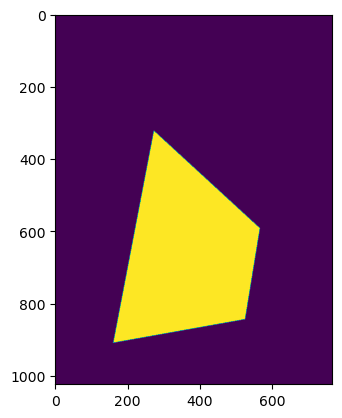

In [18]:
shorts = df.mask_shorts[0]
left_ankle = df.left_ankles[0]
right_ankle = df.right_ankles[0]
image = df.image[0]

def line_intersection(line1, line2):
    xdiff = (line1[0][0] - line1[1][0], line2[0][0] - line2[1][0])
    ydiff = (line1[0][1] - line1[1][1], line2[0][1] - line2[1][1])

    def det(a, b):
        return a[0] * b[1] - a[1] * b[0]

    div = det(xdiff, ydiff)
    if div == 0:
       raise Exception('lines do not intersect')

    d = (det(*line1), det(*line2))
    x = det(d, xdiff) / div
    y = det(d, ydiff) / div
    return x, y

def prolong_shorts(shorts, left_ankle, right_ankle):
    shorts = convex_hull_image(shorts)

    points = np.argwhere(shorts)
    top_left = points[np.argmin(points.sum(axis=1))]
    top_right = points[np.argmax(points.sum(axis=1))]
    bottom_left = points[np.argmin(points[:, 0])]
    bottom_right = points[np.argmax(points[:, 0])]
    
    ankle_line = ((left_ankle[0], left_ankle[1]), (right_ankle[0], right_ankle[1]))
    # indices = np.argwhere(shorts)
    # highest_left_point = indices[np.argmin(indices.sum(axis=1))]
    # lowest_left_point = indices[np.argmin(indices[:, 0])]
    left_line = ((top_left[0], top_left[1]), (bottom_left[0], bottom_left[1]))
    left_intersection = line_intersection(left_line, ankle_line)

    # highest_right_point = indices[np.argmax(indices[:, 1])]
    # lowest_right_point = indices[np.argmax(indices[:, 0])]
    right_line = ((top_right[0], top_right[1]), (bottom_right[0], bottom_right[1]))
    right_intersection = line_intersection(right_line, ankle_line)


    mask = Image.fromarray(np.zeros(shorts.shape, dtype=np.uint8))
    draw = ImageDraw.Draw(mask)
    draw.polygon([tuple(top_left), tuple(left_intersection), tuple(right_intersection), tuple(top_right)], outline=1, fill=1)
    mask = np.array(mask)

    return mask

imshow(prolong_shorts(shorts, left_ankle, right_ankle))
# imshow(prolong_shorts(shorts, left_ankle, right_ankle))

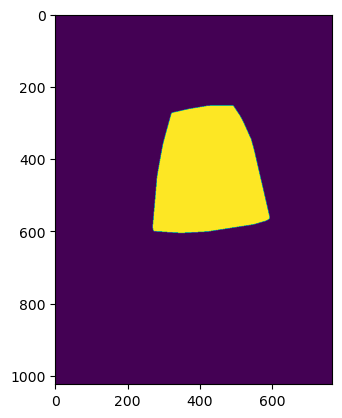

In [14]:
imshow(convex_hull_image(shorts))

In [15]:
# detect 4 corner points of convex_hull_image(shorts)
points = np.argwhere(shorts)
top_left = points[np.argmin(points.sum(axis=1))]
top_right = points[np.argmax(points[:, 1])]
bottom_left = points[np.argmin(points[:, 0])]
bottom_right = points[np.argmax(points[:, 0])]
print(top_left, top_right, bottom_left, bottom_right)

[273 323] [561 592] [253 434] [605 347]


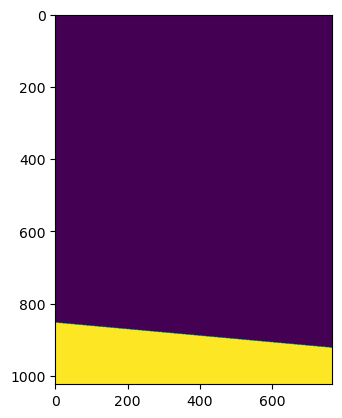

In [10]:
imshow(df.mask_ankle[1])

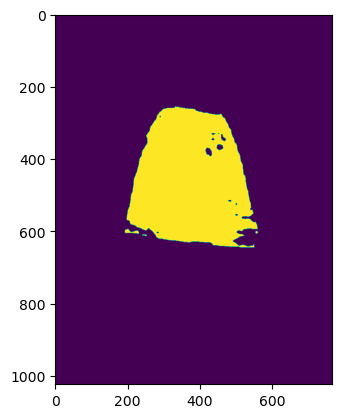

In [11]:
imshow(df.mask_shorts[1])

In [12]:
tqdm._instances.clear()
mask_prolonged_shorts = [prolong_shorts(a, b, c) for a, b, c in tqdm(zip(df.mask_shorts, df.left_ankles, df.right_ankles))]

2it [00:00,  8.64it/s]

((408.34454345703125, 429.498291015625), (343.884521484375, 323.2521057128906), 81.17961883544922)
[[222.26472 284.37274]
 [541.69403 234.8061 ]
 [594.4244  574.62384]
 [274.99506 624.1905 ]]
((396.9381408691406, 450.28704833984375), (365.2110290527344, 369.444580078125), 7.765166282653809)
[[191.04865 608.64307]
 [240.96552 242.58618]
 [602.82764 291.93103]
 [552.91077 657.9879 ]]
((381.79229736328125, 388.0443420410156), (302.7887268066406, 193.967041015625), 4.666858673095703)
[[223.0091  472.38858]
 [238.79065 279.0646 ]
 [540.5755  303.7001 ]
 [524.79395 497.02408]]


5it [00:00,  8.76it/s]

((372.48736572265625, 496.80523681640625), (491.9331970214844, 312.1629333496094), 86.26860046386719)
[[200.72946 261.5177 ]
 [512.23065 241.20241]
 [544.24524 732.0928 ]
 [232.74408 752.4081 ]]
((395.2618408203125, 582.363525390625), (354.1285095214844, 423.1623840332031), 0.7638984322547913)
[[215.39249 791.56525]
 [221.03415 368.4405 ]
 [575.1312  373.1618 ]
 [569.4895  796.28656]]


8it [00:00,  9.50it/s]

((344.9247741699219, 74.35507202148438), (187.84054565429688, 260.86102294921875), 47.321533203125)
[[185.36926   93.72445 ]
 [377.1463   -83.108925]
 [504.4803    54.985695]
 [312.70325  231.81906 ]]
((404.5, 400.0), (242.0, 253.0), 90.0)
[[278. 279.]
 [531. 279.]
 [531. 521.]
 [278. 521.]]
((319.72589111328125, 463.7090148925781), (473.2613220214844, 302.0970153808594), 81.04336547851562)
[[133.67891 253.48   ]
 [432.0923  206.44746]
 [505.7729  673.93805]
 [207.3595  720.9706 ]]


10it [00:01,  8.64it/s]

((459.5112609863281, 576.8758544921875), (462.1784973144531, 677.1964721679688), 16.484453201293945)
[[141.84152 835.9839 ]
 [333.99954 186.62234]
 [777.181   317.76782]
 [585.02295 967.1294 ]]
((375.5, 549.5), (377.0, 263.0), 90.0)
[[244. 361.]
 [507. 361.]
 [507. 738.]
 [244. 738.]]


12it [00:01,  8.27it/s]

((379.96551513671875, 459.18280029296875), (411.75640869140625, 258.3468017578125), 86.29156494140625)
[[237.74655 262.0905 ]
 [495.5524  245.38086]
 [522.18445 656.2751 ]
 [264.37863 672.98474]]
((387.0, 476.5), (459.0, 244.0), 90.0)
[[265. 247.]
 [509. 247.]
 [509. 706.]
 [265. 706.]]


14it [00:01,  7.80it/s]

((401.8209228515625, 473.61968994140625), (231.5821990966797, 412.63409423828125), 4.258845329284668)
[[271.02795 670.7681 ]
 [301.67114 259.27338]
 [532.6139  276.47125]
 [501.9707  687.966  ]]
((362.104248046875, 531.4046630859375), (273.4411315917969, 540.0890502929688), 2.544804573059082)
[[213.52838 795.11237]
 [237.50867 255.55598]
 [510.6801  267.69696]
 [486.69983 807.25336]]


16it [00:01,  8.66it/s]

((396.5, 384.5), (251.0, 249.0), 90.0)
[[272. 259.]
 [521. 259.]
 [521. 510.]
 [272. 510.]]
((376.34521484375, 194.1932373046875), (324.57342529296875, 378.71575927734375), 0.6986944079399109)
[[211.76149   381.55807  ]
 [216.37965     2.8704672]
 [540.92896     6.8283997]
 [536.3108    385.51602  ]]


18it [00:02,  8.03it/s]

((383.40252685546875, 487.0086975097656), (428.5986022949219, 230.10250854492188), 84.89783477783203)
[[249.74908 283.79022]
 [478.93988 263.32678]
 [517.05597 690.2272 ]
 [287.86517 710.6906 ]]
((419.0, 532.0), (566.0, 364.0), 90.0)
[[237. 249.]
 [601. 249.]
 [601. 815.]
 [237. 815.]]


20it [00:02,  8.60it/s]

((372.0, 471.0), (398.0, 212.0), 90.0)
[[266. 272.]
 [478. 272.]
 [478. 670.]
 [266. 670.]]
((385.0, 303.5), (581.0, 440.0), 90.0)
[[165.  13.]
 [605.  13.]
 [605. 594.]
 [165. 594.]]


23it [00:02,  9.17it/s]

((381.0, 537.5), (485.0, 310.0), 90.0)
[[226. 295.]
 [536. 295.]
 [536. 780.]
 [226. 780.]]
((395.2212829589844, 487.47711181640625), (243.48297119140625, 216.67103576660156), 1.6846843957901)
[[270.34744 592.1867 ]
 [276.71738 375.60934]
 [520.0951  382.76752]
 [513.7252  599.34485]]
((400.5325622558594, 451.70184326171875), (330.6630554199219, 373.8094482421875), 88.45184326171875)
[[209.22928 291.4803 ]
 [582.9023  281.38104]
 [591.8358  611.9234 ]
 [218.16284 622.02264]]


24it [00:02,  8.85it/s]

((384.7098693847656, 491.93408203125), (446.70538330078125, 235.5760040283203), 84.18102264404297)
[[244.88402 281.67432]
 [479.24612 257.79022]
 [524.5357  702.19385]
 [290.1736  726.07794]]
((380.9617614746094, 400.51788330078125), (238.55975341796875, 300.5438232421875), 85.47117614746094)
[[221.74063 293.476  ]
 [521.34607 269.74487]
 [540.18286 507.55975]
 [240.57745 531.2909 ]]


27it [00:03,  9.35it/s]

((380.29852294921875, 457.0531005859375), (376.566162109375, 231.7306365966797), 88.21009063720703)
[[258.60876 272.4809 ]
 [490.22632 265.24286]
 [501.98828 641.6253 ]
 [270.37073 648.86334]]
((392.4000244140625, 443.70001220703125), (250.69320678710938, 396.56134033203125), 0.9240454435348511)
[[263.87207 639.9334 ]
 [270.2674  243.42368]
 [520.928   247.46661]
 [514.53265 643.9763 ]]


29it [00:03,  8.37it/s]

((443.82427978515625, 409.2127380371094), (453.416259765625, 752.309814453125), 5.856013774871826)
[[179.92058  760.27386 ]
 [256.67792   11.890039]
 [707.72797   58.15161 ]
 [630.97064  806.53546 ]]
((399.5, 177.5), (347.0, 347.0), 90.0)
[[226.   4.]
 [573.   4.]
 [573. 351.]
 [226. 351.]]


31it [00:03,  8.34it/s]

((391.35211181640625, 250.63426208496094), (499.21343994140625, 332.7257995605469), 86.42366790771484)
[[209.74316   11.891052]
 [541.82104   -8.8638  ]
 [572.96106  489.37747 ]
 [240.88318  510.13232 ]]
((367.90240478515625, 422.5323181152344), (547.661865234375, 282.93035888671875), 85.71085357666016)
[[206.35365 160.04846]
 [488.4916  138.88812]
 [529.4512  685.0162 ]
 [247.3132  706.1765 ]]


33it [00:03,  7.30it/s]

((363.0, 486.5), (443.0, 362.0), 90.0)
[[182. 265.]
 [544. 265.]
 [544. 708.]
 [182. 708.]]
((366.7489013671875, 333.2287292480469), (625.40185546875, 397.7773132324219), 87.01570892333984)
[[151.85007   31.306458]
 [549.08795   10.59729 ]
 [581.6477   635.151   ]
 [184.40985  655.86017 ]]


35it [00:04,  7.66it/s]

((387.58123779296875, 595.8245849609375), (495.2439880371094, 309.7506103515625), 85.10960388183594)
[[212.15999 362.30716]
 [520.78296 335.9009 ]
 [563.0025  829.34204]
 [254.37952 855.7483 ]]
((376.57952880859375, 557.0347900390625), (350.7207946777344, 626.0936889648438), 1.8476102352142334)
[[191.21725 864.265  ]
 [211.40335 238.49686]
 [561.9418  249.80457]
 [541.75574 875.57275]]


37it [00:04,  6.68it/s]

((389.3953857421875, 242.38307189941406), (362.49658203125, 453.5783386230469), 3.1798300743103027)
[[195.84616   458.76923  ]
 [221.00613     5.8892384]
 [582.9446     25.996918 ]
 [557.78467   478.8769   ]]
((423.49981689453125, 426.0133056640625), (247.1913604736328, 346.7291564941406), 0.7638984322547913)
[[297.60382 597.7147 ]
 [302.22644 251.01634]
 [549.3958  254.31189]
 [544.7732  601.01025]]


39it [00:04,  6.22it/s]

((374.7563781738281, 272.8314208984375), (538.3103637695312, 308.279052734375), 89.56594848632812)
[[218.58228     4.851654 ]
 [526.8525      2.5162659]
 [530.9305    540.81116  ]
 [222.66028   543.1466   ]]
((372.6876220703125, 456.1575927734375), (373.98004150390625, 218.60983276367188), 85.03025817871094)
[[247.59476 279.3396 ]
 [465.38272 260.4015 ]
 [497.7805  632.9756 ]
 [279.99252 651.9137 ]]


41it [00:05,  7.11it/s]

((371.0, 212.0), (398.0, 290.0), 90.0)
[[226.  13.]
 [516.  13.]
 [516. 411.]
 [226. 411.]]
((379.6692199707031, 560.490966796875), (567.9534301757812, 431.4527587890625), 86.93350982666016)
[[149.06046 288.4611 ]
 [579.8954  265.38065]
 [610.27795 832.5209 ]
 [179.44305 855.6013 ]]


43it [00:05,  8.20it/s]

((390.0, 172.0), (342.0, 352.0), 90.0)
[[214.   1.]
 [566.   1.]
 [566. 343.]
 [214. 343.]]
((383.0693359375, 479.1930847167969), (444.38360595703125, 339.2081604003906), 84.2894058227539)
[[192.19804 274.98022]
 [529.72284 241.22772]
 [573.9406  683.40594]
 [236.41583 717.15845]]


45it [00:05,  8.66it/s]

((407.5, 379.5), (241.0, 271.0), 90.0)
[[272. 259.]
 [543. 259.]
 [543. 500.]
 [272. 500.]]
((377.5, 481.0), (774.0, 329.0), 90.0)
[[213.  94.]
 [542.  94.]
 [542. 868.]
 [213. 868.]]


47it [00:05,  8.10it/s]

((373.2060546875, 466.6425476074219), (260.5765686035156, 493.0585021972656), 2.2025980949401855)
[[233.53914 707.9823 ]
 [252.4889  215.28804]
 [512.873   225.3028 ]
 [493.92322 717.9971 ]]
((389.14984130859375, 505.89691162109375), (470.6441650390625, 330.04351806640625), 86.42366790771484)
[[209.77046 281.32684]
 [539.17126 260.73932]
 [568.52924 730.467  ]
 [239.12842 751.0545 ]]


49it [00:06,  7.92it/s]

((398.46136474609375, 400.7730712890625), (233.1088104248047, 342.8716735839844), 2.862405300140381)
[[273.49127 566.17456]
 [290.61346 223.73068]
 [523.43146 235.37158]
 [506.30927 577.8154 ]]
((371.4999694824219, 500.4999694824219), (324.99993896484375, 500.99993896484375), -0.0)
[[209.      750.99994]
 [209.      250.     ]
 [533.99994 250.     ]
 [533.99994 750.99994]]


51it [00:06,  8.46it/s]

((350.4384765625, 506.9923095703125), (335.0177917480469, 432.7571716308594), 7.125016689300537)
[[157.38464 700.9231 ]
 [211.06158 271.5077 ]
 [543.4923  313.06152]
 [489.81537 742.4769 ]]
((374.5, 445.0), (614.0, 237.0), 90.0)
[[256. 138.]
 [493. 138.]
 [493. 752.]
 [256. 752.]]
((397.0240478515625, 478.56988525390625), (361.4017028808594, 385.45550537109375), 7.594643592834473)
[[192.4367  645.7249 ]
 [243.37994 263.65067]
 [601.6114  311.41486]
 [550.66815 693.48914]]


54it [00:06,  8.63it/s]

((361.105224609375, 479.055419921875), (300.6553649902344, 151.30618286132812), 1.2188751697540283)
[[209.20227 551.49365]
 [212.42084 400.2217 ]
 [513.0082  406.6172 ]
 [509.7896  557.88916]]
((376.01556396484375, 458.7638244628906), (444.29083251953125, 348.9849853515625), 86.633544921875)
[[188.77937 247.24826]
 [537.1622  226.75522]
 [563.2518  670.2794 ]
 [214.86896 690.77246]]


56it [00:06,  8.12it/s]

((355.423095703125, 485.6153564453125), (391.6438903808594, 386.9371337890625), 78.69007110595703)
[[127.30772 331.53845]
 [506.7308  255.65385]
 [583.53845 639.69226]
 [204.11539 715.57684]]
((406.0, 499.5), (403.0, 252.0), 90.0)
[[280. 298.]
 [532. 298.]
 [532. 701.]
 [280. 701.]]


57it [00:06,  8.57it/s]

((369.95068359375, 487.53033447265625), (337.8437194824219, 469.18365478515625), 5.31454610824585)
[[180.02629 705.4676 ]
 [223.48369 238.30086]
 [559.87506 269.59308]
 [516.41766 736.7598 ]]


60it [00:07,  7.67it/s]

((400.8057861328125, 565.326904296875), (249.7613067626953, 607.9957275390625), 1.9091522693634033)
[[265.86682 864.9956 ]
 [286.12207 257.33743]
 [535.74475 265.6582 ]
 [515.4895  873.3164 ]]
((354.3608703613281, 403.92645263671875), (276.839111328125, 254.2504425048828), 86.90594482421875)
[[219.94974 272.57028]
 [473.82956 258.84708]
 [488.772   535.2826 ]
 [234.89218 549.00586]]
((367.3786315917969, 419.3608703613281), (363.92889404296875, 246.02964782714844), 85.76361083984375)
[[231.25792 246.9809 ]
 [476.61533 228.80627]
 [503.49933 591.74084]
 [258.14194 609.91547]]


62it [00:07,  7.44it/s]

((355.33013916015625, 470.3472595214844), (477.8962707519531, 284.54241943359375), 88.80650329589844)
[[208.11276 234.41432]
 [492.59344 228.48763]
 [502.54752 706.2802 ]
 [218.06683 712.2069 ]]
((391.3934326171875, 523.7493896484375), (533.238037109375, 305.0328063964844), 88.12212371826172)
[[230.22203 262.27142]
 [535.09106 252.2757 ]
 [552.5648  785.22736]
 [247.6958  795.2231 ]]


64it [00:07,  7.66it/s]

((388.84521484375, 459.16754150390625), (219.15591430664062, 400.1946716308594), 4.085616588592529)
[[265.28937 650.9492 ]
 [293.80206 251.77164]
 [512.40106 267.38586]
 [483.88837 666.5635 ]]
((442.72802734375, 464.27130126953125), (261.4164123535156, 422.7034912109375), 0.902221143245697)
[[308.70807 673.5387 ]
 [315.364   250.88762]
 [576.748   255.0039 ]
 [570.09204 677.65497]]


66it [00:08,  7.94it/s]

((331.3869323730469, 363.4666748046875), (423.3741760253906, 328.904296875), 79.87532806396484)
[[132.28308  183.98521 ]
 [456.06555  126.166916]
 [530.4908   542.9481  ]
 [206.70831  600.7664  ]]
((405.4046325683594, 394.1923828125), (327.3940734863281, 289.8739013671875), 4.573921203613281)
[[230.67091 525.61365]
 [253.78694 236.66295]
 [580.13837 262.77112]
 [557.02234 551.7218 ]]
((371.0277404785156, 384.7109375), (770.1696166992188, 368.30523681640625), 89.5060806274414)
[[183.56236     1.2279053]
 [551.85394    -1.9470215]
 [558.4931    768.194    ]
 [190.20154   771.3689   ]]


69it [00:08,  8.04it/s]

((359.0, 395.0), (276.0, 350.0), 90.0)
[[184. 257.]
 [534. 257.]
 [534. 533.]
 [184. 533.]]
((381.0276794433594, 517.208740234375), (453.89459228515625, 344.4300842285156), 82.43856811523438)
[[180.44637 314.8965 ]
 [521.8814  269.57327]
 [581.609   719.521  ]
 [240.17395 764.84424]]


71it [00:08,  7.77it/s]

((354.6080322265625, 441.32666015625), (222.3156280517578, 372.8093566894531), 1.6846843957901)
[[238.01813 624.3828 ]
 [248.9784  251.73462]
 [471.19794 258.2705 ]
 [460.23767 630.9187 ]]
((350.79742431640625, 396.370849609375), (247.0988311767578, 242.23533630371094), 84.95755004882812)
[[219.28928 283.94507]
 [460.58713 262.6541 ]
 [482.30557 508.79663]
 [241.00772 530.0876 ]]


73it [00:09,  7.52it/s]

((379.7884521484375, 445.5716552734375), (229.1589813232422, 366.91241455078125), 4.4846062660217285)
[[251.21509 619.5071 ]
 [279.90442 253.71802]
 [508.36182 271.63623]
 [479.6725  637.4253 ]]
((368.74176025390625, 397.69757080078125), (210.10934448242188, 244.45455932617188), 2.385944366455078)
[[258.6898  515.44543]
 [268.86655 271.2028 ]
 [478.79373 279.9497 ]
 [468.61697 524.1924 ]]


75it [00:09,  6.58it/s]

((378.0, 428.5), (315.0, 332.0), 90.0)
[[212. 271.]
 [544. 271.]
 [544. 586.]
 [212. 586.]]
((346.54656982421875, 295.1660461425781), (248.46580505371094, 403.5075378417969), 3.990912914276123)
[[208.57321 487.7842 ]
 [236.65665  85.25511]
 [484.51993 102.54788]
 [456.4365  505.07697]]


76it [00:09,  6.88it/s]

((410.6260986328125, 591.1083984375), (429.24713134765625, 632.8617553710938), 3.814074993133545)
[[175.42921 892.5619 ]
 [217.52657 261.1018 ]
 [645.823   289.6549 ]
 [603.72565 921.115  ]]
((327.30047607421875, 460.42193603515625), (370.92828369140625, 232.82652282714844), 86.74278259277344)
[[200.53748 281.87183]
 [432.98785 268.64294]
 [454.06348 638.97205]
 [221.6131  652.2009 ]]


78it [00:09,  7.69it/s]

((424.1446533203125, 494.04510498046875), (376.7271423339844, 225.037109375), 87.66268920898438)
[[304.0378  310.427  ]
 [528.88763 301.24945]
 [544.25146 677.6632 ]
 [319.40167 686.84076]]
((405.5, 527.5), (565.0, 407.0), 90.0)
[[202. 245.]
 [609. 245.]
 [609. 810.]
 [202. 810.]]


79it [00:09,  6.89it/s]

((383.5, 565.0), (630.0, 413.0), 90.0)
[[177. 250.]
 [590. 250.]
 [590. 880.]
 [177. 880.]]


Exception: lines do not intersect

In [ ]:
df['mask_prolonged_shorts'] = mask_prolonged_shorts

In [ ]:
# save processed_images to /preprocessed
SAVE_PROCESSED = True
if SAVE_PROCESSED:
    for i, img in tqdm(enumerate(processed_images_withankles)):
        img.save('C:/code/python/test_task_big/preprocessed_6/' + df.ids[i] + '.jpg')

704it [00:08, 87.11it/s] 


In [ ]:
img_cols = set(df.columns) - set(['ids', 'pose_keypoints', 'pose_json'])
img_cols = [
    'image',
    'human_parsing',
    'pose_img',
    'mask_shorts',
    'mask_legs',
    'mask_legs_and_shorts',
    'mask_shirts',
    'mask_hands',
    'mask_upper_body',
    'mask_skirts_clean',
    'mask_skirts_clean_no_outliers',
    'mask_skirts_clean_convex',
    'mask_skirts_final',
    'mask_ankle'
    'processed_images',
    'processed_images_ankles'
 ]

In [ ]:
def show_images_df(df, cols, index, save=False):
    fig, axes = plt.subplots(1, len(cols), figsize=(20, 20))
    for i, col in enumerate(cols):
        axes[i].imshow(df[col][index])
        axes[i].set_title(col)
    if save:
        fig.savefig('full_outs/' + df.ids[index] + '.jpg')
    else:
        plt.show()

In [ ]:
img_cols = ['mask_ankle', 'processed_images', 'processed_images_ankles', 'mask_shorts', 'human_parsing', 'mask_skirts_clean', 'mask_skirts_clean_no_outliers', 'mask_prolonged_shorts']

In [ ]:
df[df.ids.str.contains('168764')].index

Int64Index([1], dtype='int64')

In [ ]:
df[df.ids.str.contains('178842')].index

Int64Index([229], dtype='int64')

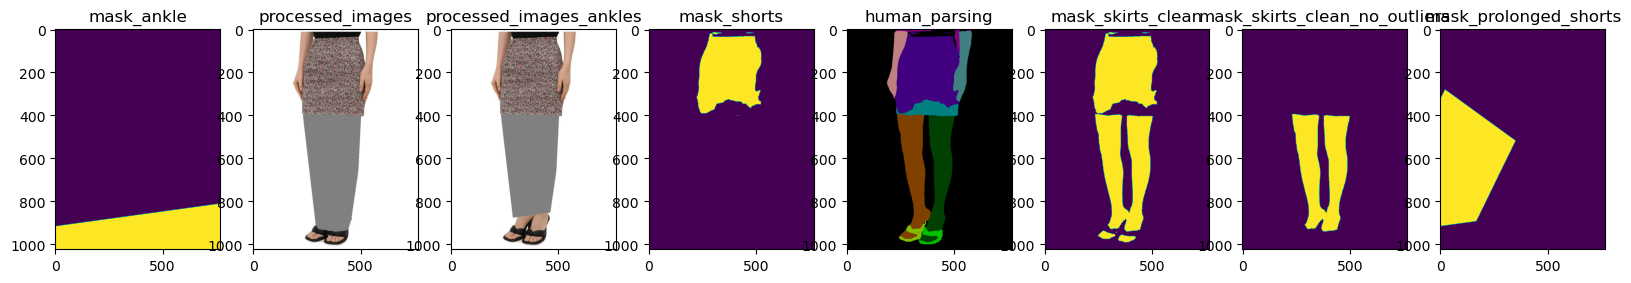

In [ ]:
show_images_df(df, img_cols, 229)

In [ ]:
# HELPER FUNCTIONS
# def draw_pose(img, poses):
#     draw = ImageDraw.Draw(img)
#     for i in range(0, len(poses), 3):
#         draw.ellipse((poses[i]-5, poses[i+1]-5, poses[i]+5, poses[i+1]+5), fill=(255, 0, 0, 255))
#         draw.text((poses[i], poses[i+1]), str(i//3), fill=(255, 0, 0, 0), font= ImageFont.truetype("arial.ttf", 30))
#     return img
# draw_pose(df.image[0], df.pose_keypoints[0])

